<b> Word Similarity </b> <br>
Your next step is to evaluate the three kinds of embeddings in the word similarity
task. The goal of this task is to compute similarity of two words and
evaluate the model-produced similarity against human judgements. Download
two commonly-used word similarity datasets:<br>
• SimLex: https://www.cl.cam.ac.uk/˜fh295/simlex.html<br>
• MEN: https://staff.fnwi.uva.nl/e.bruni/MEN<br>
Compute cosine similarity between the words using the three models. Evaluate
the model-produced similarities against human judgements in terms of
Pearson and Spearman correlation coefficients. <br>
Compare the performance of
the three models on this task. <br>
Analyze the data qualitatively and report what
are the differences in the kind of similarity captured by the three models.<br> We
are interested to see both quantitative results and qualitative analysis in your
report.

In [38]:
def read_in_SimLex():
    # Read in the SimLex dataset
    SimLex_file = open('SimLex-999/SimLex-999.txt','r')
    SimLex_set = {}
    next(SimLex_file)
    for line in SimLex_file:
        pair_data = [x.strip() for x in line.split('\t')]
        word1 = pair_data[0]
        word2 = pair_data[1]
        similarity_score = pair_data[4]
        SimLex_set[(word1, word2)] = {'human':similarity_score}
    return SimLex_set


In [24]:
# Read in the MEN dataset
def read_in_MENS():
    MEN_file = open('MEN/MEN_dataset_natural_form_full','r')
    MEN_set = {}
    for line in MEN_file:
        pair_data = [x.strip() for x in line.split(' ')]
        word1 = pair_data[0]
        word2 = pair_data[1]
        similarity_score = pair_data[2]
        MEN_set[(word1, word2)] = {'human':similarity_score}
    return MEN_set

In [25]:
# In order to reduce the size of the word embedding files,
#  I will delete all non-occuring words from the relevant model and
# store the word embeddings in a defaultdict for quick access.
def get_occuring_words(MEN_set, SimLex_set):
    occuring_words = []
    for pair in list(MEN_set.keys())+list(SimLex_set.keys()):
        word1 = pair[0]
        word2 = pair[1]
        if word1 not in occuring_words:
            occuring_words.append(word1)
        if word2 not in occuring_words:
            occuring_words.append(word2)
    return occuring_words

In [26]:
# Read in the word vectors for a given word model
import os
import time
from collections import defaultdict

# switch between 'bow5.words', 'bow2.words' and 'deps.words'
def get_embeddings(filename, occuring_words):
    # Returns a dictionary containing words as keys and word vectors
    #  as values
    if filename+'_small' in os.listdir():
        f = open(filename+'_small')
        using_small = True
    else:
        f = open(filename,'r')
        d = open(filename+'_small','w')
    word_embeddings = defaultdict(list)
    i =0
    s = time.time()
    for line in f:
        entry = [x.strip() for x in line.split(' ')]
        word = entry[0]
        vector = entry[1:]
        if word in occuring_words:
            word_embeddings[word] = [np.float(x) for x in vector]
            if not using_small:
                d.write(line)
    if not using_small:
        d.close()
    f.close()
    e = time.time()
    print('It took {} seconds to read in dataset {}'.format(e-s,filename))
    return word_embeddings



In [27]:
import numpy as np
import math
def cosine_similarity(v1, v2,n1, n2):
    # Returns a value between -1 and 1, 1 meaning exactly same
    #  and -1 meaning exactly opposite.
    assert len(v1) == len(v2)
    numerator = sum([v1[i]*v2[i] for i in range(len(v1))])
    denominator = np.sqrt(sum([x**2 for x in v1])) \
                * np.sqrt(sum([x**2 for x in v2]))
    if denominator == 0:
        print('division by zero with words:')
        print(n1)
        print(n2)
    return (numerator/denominator)

In [59]:

def add_cosine_similarity(dataset, word_embeddings):
    # Computes the cosine similarity per word pair and adds
    #  it to the pair dictionary entry.
    for pair in list(dataset.keys()):
        v1, v2 = word_embeddings[pair[0]], word_embeddings[pair[1]]
        if len(v1) != len(v2):
            if len(v1) == 0 or len(v2) == 0:
                print('Removing {} and {} from dataset'.format(pair[0],pair[1]))
                print('No word embedding found for one of them')
                del dataset[pair]
            else:
                print("Something weird happened with:")
                print(pair[0], pair[1])
        else:
            cos_sim = cosine_similarity(v1,v2,pair[0],pair[1])
            dataset[pair]['cos_sim'] = cos_sim
    return dataset

def get_just_data(dataset):
    # Returns the human judgements and cosine similarities 
    # as a nx2 numpy array for easy data anaylsis
    n = len(dataset)
    result = np.zeros((2,n))
    for i,pair in enumerate(list(dataset.keys())):
        result[0,i] = dataset[pair]['human']
        result[1,i] = dataset[pair]['cos_sim']
    return result



In [60]:
def get_similarity_measures(filename):
    s = time.time()
    MEN_set = read_in_MENS()
    SimLex_set = read_in_SimLex()
    occuring_words = get_occuring_words(MEN_set, SimLex_set)
    word_embeddings = get_embeddings(filename,occuring_words)
    MEN_set = add_cosine_similarity(MEN_set, word_embeddings)
    SimLex_set = add_cosine_similarity(SimLex_set, word_embeddings)
    MEN_data = get_just_data(MEN_set)
    SimLex_data = get_just_data(SimLex_set)
    e = time.time()
    print('Getting similarity measures on {} took {} seconds'.format(filename,(e-s)))
    return MEN_data, SimLex_data

In [61]:
# Read in the three datasets
MEN_k2, Sim_k2 = get_similarity_measures('bow2.words')
MEN_k5, Sim_k5 = get_similarity_measures('bow5.words')
MEN_deps, Sim_deps = get_similarity_measures('deps.words')


It took 0.18975138664245605 seconds to read in dataset bow2.words
Removing disorganize and organize from dataset
No word embedding found for one of them
Getting similarity measures on bow2.words took 0.6416621208190918 seconds
It took 0.20302033424377441 seconds to read in dataset bow5.words
Removing disorganize and organize from dataset
No word embedding found for one of them
Getting similarity measures on bow5.words took 0.6934762001037598 seconds
It took 0.19661569595336914 seconds to read in dataset deps.words
Removing disorganize and organize from dataset
No word embedding found for one of them
Getting similarity measures on deps.words took 0.661745548248291 seconds


In [85]:
x = MEN_k5[1,:]
enumerate(x)

-0.03140872863290265
-0.027995780899783496


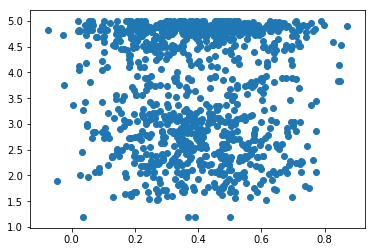

In [138]:
def calc_Pearson_correlation(data):
    # data[0,:] are the human observations
    # data[1,:] are the computed cosine similarities
    assert data.shape[0] == 2, 'Data must have two measures per variable.'
    cov_matrix = np.cov(data)
    assert cov_matrix[1,0] == cov_matrix[0,1],'These should be same...'
    cov_hum_cos = cov_matrix[1,0]
    std_hum = np.std(data[0,:])
    std_cos = np.std(data[1,:])
    rho = cov_hum_cos/(std_hum*std_cos)
    return rho

def calc_Spearman_correlation(data):
    n = len(data[0,:])
    d = data[:,data[0,:].argsort()] # data sorted on human judgements
    ranked_data = np.array([d[0,:].argsort(),d[1,:].argsort()])
    dif = [ranked_data[0,i]-ranked_data[1,i] for i in range(n)]
    dif_sq = [x**2 for x in dif]
    rho = 1 - ((6*sum(dif_sq))/(n*(n**2 -1)))
    return rho

print(calc_Pearson_correlation(Sim_k5))
print(calc_Spearman_correlation(Sim_k5))
import matplotlib.pyplot as plt

plt.scatter(Sim_k5[1,:],Sim_k5[0,:])
plt.show()